In [11]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

(content:examples:race_car)=
# Race car Lap Simulation

```{admonition} Things you'll learn through this example
- Optimizing trajectories for cyclic events (such as race car laps)
    - Linking a phase with itself so it is ensured that start and end states are identical
- Using an independent variable other than time
```

```{admonition} The race track problem
_The race track problem is different from other dymos example problems in that it is a cyclic problem.
The solution must be such that the start and end states are identical. The problem for this example
is given a race track shape, what is the optimum values for the controls such that the time elapsed to complete
the track is a minimum._
```

## Background of the problem

This example is based on the work of [Pieter de Buck](http://www.formulae.one/contact)
The goal of his problem was to find an optimal trajectory for the race car with active aerodynamic and
four wheel drive controls.

Pieter posted an [issue](https://github.com/OpenMDAO/dymos/issues/369) to the Dymos repository asking
how to use dymos for cyclic events such as this. His solution involved using an iterative solution, which worked but
dymos includes a feature that allows for simple and more efficient solution.
This example shows how to handle this situation using simple dymos calls without iteration.

If you are interested, Pieter and Adeline Shin have created an
[interactive visualization](http://www.formulae.one/lapsimulation) using his version of the code.

While Pieter's code includes several actual race tracks shapes, for simplicity and speed of solution, this dymos
example uses an oval track. If you
are interested in trying other race tracks, they are defined in the
[tracks.py](https://github.com/OpenMDAO/dymos/tree/master/dymos/examples/racecar/tracks.py) file.

## Optimizing trajectories for cyclic events

For trajectory optimization of cyclic events (such as race car laps), there needs to be
a way that ensure that the start and end states are identical.

In this race car example, the states and controls such as velocity, thrust, and steering angle need
to be the same at the start and finish.

Linking the controls is not really needed since it generally follows from the linked states.

There is a simple way to link the states of cyclic events in dymos.
You can use the `Trajectory.link_phases` functionality to "link" a
phase with itself. In this example this is accomplished with the following code which links all 7 state
variables.

```python
traj.link_phases(phases=['phase0', 'phase0'], vars=['V','n','alpha','omega','lambda','ax','ay'], locs=('final', 'initial'))
```

This code causes the value of `V` at the end of `phase0` ('final') to be linked via constraint
to the value of `V` at the beginning ('initial') of `phase0`.
This call does the same for the other 6 state variables as well.

See the [Trajectory API page](https://openmdao.github.io/dymos/api/trajectory_api.html)
for more information about the `link_phases` method.

## Using an independent variable other than time

In all the other dymos examples, time is the independent variable.
In this race car example, the independent variable is the arc length along the track.
Integration is done from the start of the track to the end.
The “typical” equations of motion are computed, so the rate of change of x wrt time (**$\frac{dx}{dt}$**).

By dividing the rates of change w.r.t. time by (**$\frac{ds}{dt}$**),
the rates of change of the states w.r.t. track arclength traversed are computed.

## Definition of the problem

Here are some figures which help define the problem.

This table describes the controls, states, and constraints. The symbols match up with the
variable names in the code shown at the bottom of this page.

### Table 1. Optimization problem formulation

|                     |                               | Symbol    | Lower | Upper | Units      |
|---------------------|-------------------------------|-----------|-------|-------|------------|
| **Minimize**        | Time                          |         t |       |       |          s |
| **With respect to** |                               |           |       |       |            |
| **Controls**        | Front left thrust             | $T_{fl}$  |       |       |            |
|                     | Front right thrust            | $T_{fr}$  |       |       |            |
|                     | Rear left thrust              | $T_{rl}$  |       |       |            |
|                     | Rear right thrust             | $T_{rr}$  |       |       |            |
|                     | Rear wing flap angle          | $\gamma$  |     0 |    50 |        deg |
|                     | Steering angle                |  $\delta$ |       |       |        rad |
| **States**          | Speed                         |         V |       |       |  $ms^{-1}$ |
|                     | Longitudinal acceleration     |     $a_x$ |       |       | $ms^{-2}$  |
|                     | Lateral acceleration          |     $a_y$ |       |       | $ms^{-2}$  |
|                     | Normal distance to centerline |         n |    -4 |     4 |          m |
|                     | Angle relative to centerline  |  $\alpha$ |       |       |        rad |
|                     | Slip angle                    | $\lambda$ |       |       |        rad |
|                     | Yaw rate                      | $\Omega$  |       |       | $rad^{-1}$ |
| **Subject to**      | Front left adherence          | $c_{fl}$  |     0 |     1 |            |
|                     | Front right adherence         | $c_{fr}$  |     0 |     1 |            |
|                     | Rear left adherence           | $c_{rl}$  |     0 |     1 |            |
|                     | Rear right adherence          | $c_{rr}$  |     0 |     1 |            |
|                     | Front left power              | $P_{fl}$  |       |    75 |         kW |
|                     | Front right power             | $P_{fr}$  |       |    75 |         kW |
|                     | Rear left power               | $P_{rl}$  |       |    75 |         kW |
|                     | Rear right power              | $P_{rr}$  |       |    75 |         kW |
|                     | Periodic state constraints    |           |       |       |            |
|                     | System dynamics               |           |       |       |            |
|                     | Track Layout                  |           |       |       |            |

The next figure defines the vehicle parameters. Again, the symbols match up with the
variable names in the code.

### Table 2. Vehicle parameters

| Parameter      | Value                                | Units        | Description                                |
|----------------|--------------------------------------|--------------|--------------------------------------------|
| $M$            | 1184                                 | $kg$         | Vehicle mass                               |
| $a$            | 1.404                                | $m$          | CoG to front axle distance                 |
| $b$            | 1.356                                | $m$          | CoG to rear axle distance                  |
| $t_w$          | 0.807                                | $m$          | Half track width                           |
| $h$            | 0.4                                  | $m$          | CoG height                                 |
| $I_z$          | 1775                                 | $kg\ m^{2}$  | Yaw inertia                                |
| $\beta$        | 0.62                                 | -            | Brake balance                              |
| $\chi$         | 0.5                                  | -            | Roll stiffness                             |
| $\rho$         | 1.2                                  | $kg\ m^{-3}$ | Air density                                |
| $\mu_{0}^{x}$  | 1.68                                 | -            | Longitudinal base friction coefficient     |
| $\mu_{0}^{y}$  | 1.68                                 | -            | Lateral base friction coefficient          |
| $K_{\mu}$      | -0.5                                 | -            | Tire load sensitivity                      |
| $K_{\lambda}$  | 44                                   | -            | Tire lateral stiffness                     |
| $\tau_{a_{x}}$ | 0.2                                  | $s$          | Longitudinal load transfer time constant   |
| $\tau_{a_{y}}$ | 0.2                                  | $s$          | Lateral load transfer time constant        |
| $S_{w}$        | 0.8                                  | $m^{2}$      | Wing planform area                         |
| $CoP$          | 1.404                                | $m$          | Center of pressure to front axle distance  |

There is also a figure which describes the states that govern the vehicle position
relative to the track.

![Vehicle Position States](https://github.com/OpenMDAO/dymos/blob/master/docs/dymos_book/examples/racecar/vehicle_position_states.png?raw=1)

Here is the code to solve this problem:

In [12]:
import numpy as np
import openmdao.api as om

class MPCController(om.ExplicitComponent):
    """
    Basit bir 'MPC benzeri' bileşen:
      delta_mpc = -K_n * n - K_alpha * alpha
      thrust_mpc = az kısıtları yüksekse thrust azalt
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int,
                             desc='Number of nodes for the phase transcription.')

    def setup(self):
        nn = self.options['num_nodes']

        # Girdiler
        self.add_input('n', shape=(nn,), units='m',
                       desc='Track normal displacement')
        self.add_input('alpha', shape=(nn,), units='rad',
                       desc='Heading angle w.r.t track centerline')
        self.add_input('V', shape=(nn,), units='m/s',
                       desc='Vehicle speed')
        self.add_input('ax', shape=(nn,), units='m/s**2',
                       desc='Longitudinal acceleration')
        self.add_input('ay', shape=(nn,), units='m/s**2',
                       desc='Lateral acceleration')

        # Çıktılar
        self.add_output('delta_mpc', shape=(nn,), units='rad',
                        desc='Steering angle command from MPC')
        self.add_output('thrust_mpc', shape=(nn,), units=None,
                        desc='Thrust command from MPC')

        # Basit yaklaşım: türevleri 0 varsayıyoruz (explicit formül)
        # (gerçek MPC olsa partials -> numeric veya analitik türevler)
        self.declare_partials('*', '*', val=0.0)

    def compute(self, inputs, outputs):
        n = inputs['n']
        alpha = inputs['alpha']
        V = inputs['V']
        ax = inputs['ax']
        ay = inputs['ay']

        # MPC parametreleri (örnek/naif)
        K_n = 0.2
        K_alpha = 0.1

        # Steering kontrolü:
        # P-kontrol: delta = -K_n * n - K_alpha * alpha
        # (n=0 ve alpha=0 konumunu korumaya çalışır)
        outputs['delta_mpc'] = -K_n * n - K_alpha * alpha

        # Thrust kontrolü:
        # Yanal ivme artınca (|ay| büyükse) hız/keskin dönüş riskini azaltmak için thrust'ı kıs
        # Basitçe linear clamp.
        g = 9.81
        ay_max = 0.25 * g  # 0.25*g = ~2.45 m/s^2
        ay_ratio = np.clip(np.abs(ay) / ay_max, 0.0, 1.0)

        # Tam gaz = 0.5 (örnek), Fren = -0.5 (örnek)
        thrust_full = 0.5
        thrust_min = -0.5

        # ay ne kadar artarsa thrust o kadar düşsün
        # thrust = 0.5 * (1 - ay_ratio)
        # Sonra -0.5 ile +0.5 arası clamp
        raw_thrust = thrust_full * (1.0 - ay_ratio)
        outputs['thrust_mpc'] = np.clip(raw_thrust, thrust_min, thrust_full)


In [15]:
om.display_source("dymos.examples.racecar.combinedODE")

import openmdao.api as om

from .carODE import CarODE
from .tireODE import TireODE
from .normalForceODE import NormalForceODE
from .accelerationODE import AccelerationODE
from .tireConstraintODE import TireConstraintODE
from .timeODE import TimeODE
from .timeAdder import TimeAdder
from .curvature import Curvature


class CombinedODE(om.Group):
    def initialize(self):
        self.options.declare("num_nodes", types=int,
                             desc="Number of nodes to be evaluated in the RHS")

    def setup(self):
        nn = self.options["num_nodes"]

        self.add_subsystem(name="normal", subsys=NormalForceODE(num_nodes=nn),
                           promotes_inputs=["ax", "ay", "V"],
                           promotes_outputs=["N_fr", "N_fl", "N_rr", "N_rl"], )

        self.add_subsystem(name="tire", subsys=TireODE(num_nodes=nn),
                           promotes_inputs=["lambda", "omega", "V", "N_fr", "N_fl", "N_rr", "N_rl",
                                            "thrust", "delta", ],
                           promotes_outputs=["S_fr", "S_fl", "S_rr", "S_rl", "F_fr", "F_fl", "F_rr",
                                             "F_rl", ], )

        self.add_subsystem(name="curv", subsys=Curvature(num_nodes=nn))

        self.connect("curv.kappa", "car.kappa")

        self.add_subsystem(name="car", subsys=CarODE(num_nodes=nn),
                           promotes_inputs=["n", "alpha", "V", "lambda", "omega", "S_fr", "S_fl",
                                            "S_rr", "S_rl", "F_fr", "F_fl", "F_rr", "F_rl",
                                            "delta", ],
                           promotes_outputs=["sdot", "ndot", "alphadot", "omegadot", "Vdot",
                                             "lambdadot", "power", ], )

        self.add_subsystem(name="accel", subsys=AccelerationODE(num_nodes=nn),
                           promotes_inputs=["V", "lambda", "omega", "Vdot", "lambdadot", "ax",
                                            "ay"], promotes_outputs=["axdot", "aydot"], )

        self.add_subsystem(name="tireconstraint", subsys=TireConstraintODE(num_nodes=nn),
                           promotes_inputs=["S_fr", "S_fl", "S_rr", "S_rl", "F_fr", "F_fl", "F_rr",
                                            "F_rl", "N_fr", "N_fl", "N_rr", "N_rl", ],
                           promotes_outputs=["c_rr", "c_rl", "c_fr", "c_fl"], )

        self.add_subsystem(name="time", subsys=TimeODE(num_nodes=nn),
                           promotes_inputs=["ndot", "sdot", "omegadot", "lambdadot", "Vdot",
                                            "axdot", "aydot", "alphadot", ],
                           promotes_outputs=["dn_ds", "dV_ds", "domega_ds", "dlambda_ds",
                                             "dalpha_ds", "dax_ds", "day_ds", ], )

        self.add_subsystem(name="timeAdder", subsys=TimeAdder(num_nodes=nn),
                           promotes_inputs=["sdot"], promotes_outputs=["dt_ds"], )

In [14]:
import openmdao.api as om

from .carODE import CarODE
from .tireODE import TireODE
from .normalForceODE import NormalForceODE
from .accelerationODE import AccelerationODE
from .tireConstraintODE import TireConstraintODE
from .timeODE import TimeODE
from .timeAdder import TimeAdder
from .curvature import Curvature
from .mpc_controller import MPCController  # Yukarıda tanımladığımız bileşeni ekliyoruz.

class CombinedODE(om.Group):
    def initialize(self):
        self.options.declare("num_nodes", types=int,
                             desc="Number of nodes to be evaluated in the RHS")

    def setup(self):
        nn = self.options["num_nodes"]

        # Eklediğimiz MPC alt sistemi:
        self.add_subsystem(
            name="mpc",
            subsys=MPCController(num_nodes=nn),
            promotes_inputs=["n", "alpha", "V", "ax", "ay"],
            promotes_outputs=["delta_mpc", "thrust_mpc"]
        )

        # Normal Force ODE (aynı)
        self.add_subsystem(
            name="normal",
            subsys=NormalForceODE(num_nodes=nn),
            promotes_inputs=["ax", "ay", "V"],
            promotes_outputs=["N_fr", "N_fl", "N_rr", "N_rl"]
        )

        # Tire ODE: direksiyon ve thrust artık mpc’den geliyor
        self.add_subsystem(
            name="tire",
            subsys=TireODE(num_nodes=nn),
            promotes_inputs=["lambda", "omega", "V", "N_fr", "N_fl", "N_rr", "N_rl"],
            promotes_outputs=["S_fr", "S_fl", "S_rr", "S_rl", "F_fr", "F_fl", "F_rr", "F_rl"]
        )
        # Direksiyon (delta) ve thrust (thrust) 'promotes_inputs' içinde mpc çıktısına bağlanacak
        # Bu şekilde: "delta" <--- "delta_mpc", "thrust" <--- "thrust_mpc"
        # Bunu 'connect' veya 'promotes' ile yapabiliriz. Aşağıda "promotes_inputs" içine ekliyoruz:
        self.promotes('tire', inputs=[('delta', 'delta_mpc'),
                                      ('thrust', 'thrust_mpc')])

        # Curvature
        self.add_subsystem(name="curv", subsys=Curvature(num_nodes=nn))
        self.connect("curv.kappa", "car.kappa")

        # Car ODE
        self.add_subsystem(
            name="car",
            subsys=CarODE(num_nodes=nn),
            promotes_inputs=["n", "alpha", "V", "lambda", "omega",
                             "S_fr", "S_fl", "S_rr", "S_rl",
                             "F_fr", "F_fl", "F_rr", "F_rl"],
            promotes_outputs=["sdot", "ndot", "alphadot", "omegadot", "Vdot",
                              "lambdadot", "power"]
        )
        # Yine car ODE içinde de direksiyon "delta" olarak var, mpc.delta_mpc ile bağlayalım:
        self.promotes('car', inputs=[('delta', 'delta_mpc')])

        # Acceleration ODE
        self.add_subsystem(
            name="accel",
            subsys=AccelerationODE(num_nodes=nn),
            promotes_inputs=["V", "lambda", "omega", "Vdot", "lambdadot", "ax", "ay"],
            promotes_outputs=["axdot", "aydot"]
        )

        # Tire constraint
        self.add_subsystem(
            name="tireconstraint",
            subsys=TireConstraintODE(num_nodes=nn),
            promotes_inputs=["S_fr", "S_fl", "S_rr", "S_rl",
                             "F_fr", "F_fl", "F_rr", "F_rl",
                             "N_fr", "N_fl", "N_rr", "N_rl"],
            promotes_outputs=["c_rr", "c_rl", "c_fr", "c_fl"]
        )

        # Time ODE
        self.add_subsystem(
            name="time",
            subsys=TimeODE(num_nodes=nn),
            promotes_inputs=["ndot", "sdot", "omegadot", "lambdadot", "Vdot",
                             "axdot", "aydot", "alphadot"],
            promotes_outputs=["dn_ds", "dV_ds", "domega_ds", "dlambda_ds", "dalpha_ds",
                              "dax_ds", "day_ds"]
        )

        # TimeAdder
        self.add_subsystem(
            name="timeAdder",
            subsys=TimeAdder(num_nodes=nn),
            promotes_inputs=["sdot"],
            promotes_outputs=["dt_ds"]
        )


ImportError: attempted relative import with no known parent package

In [16]:
import numpy as np
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
import matplotlib as mpl

# Burada oval track import'ları, spline fonksiyonları, vs. ... (eskisiyle aynı)
from dymos.examples.racecar.tracks import ovaltrack
from dymos.examples.racecar.spline import (
    get_spline, get_track_points, get_gate_normals,
    reverse_transform_gates, set_gate_displacements,
    transform_gates
)
from dymos.examples.racecar.linewidthhelper import linewidth_from_data_units

# Kendi CombinedODE (içinde MPCController eklenmiş hal) import ediyoruz:
from dymos.examples.racecar.combinedODE import CombinedODE

# 1) Pist tanımı
track = ovaltrack
points = get_track_points(track)
finespline, gates, gatesd, curv, slope = get_spline(points, s=0.0)
s_final = track.get_total_length()

# 2) OpenMDAO problem
p = om.Problem(model=om.Group())

# 3) Trajectory / Phase
traj = dm.Trajectory()
p.model.add_subsystem('traj', subsys=traj)

phase = dm.Phase(
    ode_class=CombinedODE,
    transcription=dm.GaussLobatto(num_segments=30, order=3, compressed=True)
)
traj.add_phase(name='phase0', phase=phase)

# 4) s (mesafe) ayarı
phase.set_time_options(
    fix_initial=True, fix_duration=True,
    units='s',  # Normalde 'time' ama biz "distance along track" ile entegre ediyoruz
)
# Yukarıdakini normal "time" gibi bıraksak da, asıl "integral var" ismini phase.set_integ_var_options(..., name='s') diye de tanımlanabilir.
# Bu örnekte "time" = 0 -> ?

phase.set_time_options(initial_val=0.0, duration_val=s_final, units='m')

# 5) State tanımları: n, V, alpha, lambda, omega, ax, ay, t
#    Pist 3.5 m => n in [-1.75, 1.75]
phase.add_state('t', fix_initial=True, fix_final=False, units='s', rate_source='dt_ds')
phase.add_state('n', fix_initial=False, fix_final=False,
                lower=-1.75, upper=1.75, units='m',
                rate_source='dn_ds', targets=['n'])
phase.add_state('V', fix_initial=False, fix_final=False, units='m/s',
                rate_source='dV_ds', targets=['V'])
phase.add_state('alpha', fix_initial=False, fix_final=False, units='rad',
                rate_source='dalpha_ds', targets=['alpha'])
phase.add_state('lambda', fix_initial=False, fix_final=False, units='rad',
                rate_source='dlambda_ds', targets=['lambda'])
phase.add_state('omega', fix_initial=False, fix_final=False, units='rad/s',
                rate_source='domega_ds', targets=['omega'])
phase.add_state('ax', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='dax_ds', targets=['ax'])
phase.add_state('ay', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='day_ds', targets=['ay'])

# 6) Parametre veya sabit tanımları (ağırlık, aerodinamik vs.)
phase.add_parameter('M', val=800.0, units='kg', opt=False,
                    targets=['car.M', 'tire.M', 'tireconstraint.M', 'normal.M'])
# ... vb. Diğer parametreler eskisi gibi.

# 7) Kısıtlar
#    a) Lateral ivme: -0.25*g ... +0.25*g ~= -2.45 ... +2.45
g = 9.81
ay_max = 0.25*g
phase.add_path_constraint('ay', lower=-ay_max, upper=ay_max)

#    b) Boylamsal ivme: -3.5 ... +3.5
phase.add_path_constraint('ax', lower=-3.5, upper=3.5)

#    c) Lastik tutunma vs. (örnek)
phase.add_path_constraint('c_rr', upper=1.0)
phase.add_path_constraint('c_rl', upper=1.0)
phase.add_path_constraint('c_fr', upper=1.0)
phase.add_path_constraint('c_fl', upper=1.0)

#    d) Motor gücü
pmax = 960000.0
phase.add_path_constraint('power', upper=pmax)

# 8) Periyodik koşul (tam tur)
traj.link_phases(
    phases=['phase0', 'phase0'],
    vars=['V','n','alpha','omega','lambda','ax','ay'],
    locs=('final', 'initial')
)

# 9) Nesne fonksiyonu: Final süresini minimize et
phase.add_objective('t', loc='final')

# 10) Sürücü (optimizer) ayarları
p.driver = om.pyOptSparseDriver(optimizer='IPOPT')
p.driver.opt_settings['max_iter'] = 500
p.driver.opt_settings['tol'] = 1e-3
p.driver.declare_coloring()

# 11) Problem setup
p.setup(check=True)

# 12) Başlangıç tahminleri
phase.set_state_val('V', 20.0)
phase.set_state_val('n', 0.0)
phase.set_state_val('alpha', 0.0)
phase.set_state_val('lambda', 0.0)
phase.set_state_val('omega', 0.0)
phase.set_state_val('ax', 0.0)
phase.set_state_val('ay', 0.0)
phase.set_state_val('t', [0.0, 50.0])  # tahmini tur süresi ~50sn gibi

# 13) Çalıştır (Optimizasyonu başlat)
dm.run_problem(p, run_driver=True)

print("Optimizasyon tamamlandı.")
print("Final tur süresi:", p.get_val('traj.phase0.timeseries.t')[-1], "s")

# 14) Sonuçlar
s_vals = p.get_val('traj.phase0.timeseries.time')  # Aslında distance 's' gibi kullanılıyor
n_vals = p.get_val('traj.phase0.timeseries.n')
V_vals = p.get_val('traj.phase0.timeseries.V')
ax_vals = p.get_val('traj.phase0.timeseries.ax')
ay_vals = p.get_val('traj.phase0.timeseries.ay')
delta_mpc = p.get_val('traj.phase0.timeseries.delta_mpc')
thrust_mpc = p.get_val('traj.phase0.timeseries.thrust_mpc')

# Plot vs. ...
# (burada kendi istediğiniz çizimleri yapabilirsiniz.)



--- Constraint Report [traj] ---
    --- phase0 ---
        [path]    -2.4525e+00 <= ay <= 2.4525e+00  [m/s**2]
        [path]    -3.5000e+00 <= ax <= 3.5000e+00  [m/s**2]
        [path]     c_rr <= 1.0000e+00  [None]
        [path]     c_rl <= 1.0000e+00  [None]
        [path]     c_fr <= 1.0000e+00  [None]
        [path]     c_fl <= 1.0000e+00  [None]
        [path]     power <= 9.6000e+05  [W]

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.002800 sec).
INFO: checking system...
INFO:     system check complete (0.000152 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.001131 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000788 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.004431 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (

/usr/local/lib/python3.10/dist-packages/openmdao/core/total_jac.py:1728: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->c_rr', inds=[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0)]), ('traj.phases.phase0->path_

KeyboardInterrupt: 

KeyboardInterrupt: 

KeyboardInterrupt: 



Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                  355.5391
       User Objective Time :      17.7129
       User Sensitivity Time :    32.7057
       Interface Time :           12.2088
       Opt Solver Time:          292.9116
    Calls to Objective Function :    2646
    Calls to Sens Function :          331


   Objectives
      Index  Name                            Value
          0  traj.phase0.states:t     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name                           Type      Lower Bound            Value      Upper Bound     Status
          0  traj.phase0.states:t_0            c    -1.000000E+21     7.165199E+02     1.000000E+21           
          1  traj.phase0.states:t_1            c    -1.000000E+21     1.463784E+03     1.000000E+21           
         

KeyboardInterrupt: 

In [17]:
%matplotlib inline

In [18]:
import numpy as np
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
import matplotlib as mpl

from dymos.examples.racecar.combinedODE import CombinedODE
from dymos.examples.racecar.spline import (get_spline, get_track_points, get_gate_normals,
                                           reverse_transform_gates, set_gate_displacements,
                                           transform_gates, )
from dymos.examples.racecar.linewidthhelper import linewidth_from_data_units
from dymos.examples.racecar.tracks import ovaltrack  # track curvature imports

# change track here and in curvature.py. Tracks are defined in tracks.py
track = ovaltrack

# generate nodes along the centerline for curvature calculation (different
# than collocation nodes)
points = get_track_points(track)

# fit the centerline spline.
finespline, gates, gatesd, curv, slope = get_spline(points, s=0.0)
# by default 10000 points
s_final = track.get_total_length()

# Define the OpenMDAO problem
p = om.Problem(model=om.Group())

# Define a Trajectory object
traj = dm.Trajectory()
p.model.add_subsystem('traj', subsys=traj)

# Define a Dymos Phase object with GaussLobatto Transcription
phase = dm.Phase(ode_class=CombinedODE,
                 transcription=dm.GaussLobatto(num_segments=50, order=3, compressed=True))

traj.add_phase(name='phase0', phase=phase)

# Set the time options, in this problem we perform a change of variables. So 'time' is
# actually 's' (distance along the track centerline)
# This is done to fix the collocation nodes in space, which saves us the calculation of
# the rate of change of curvature.
# The state equations are written with respect to time, the variable change occurs in
# timeODE.py
# Here we're using set_integ_var_options, which is just an alias for set_time_options.
phase.set_integ_var_options(fix_initial=True, fix_duration=True, duration_val=s_final,
                            targets=['curv.s'], units='m', duration_ref=s_final,
                            duration_ref0=10, name='s')

# Define states
phase.add_state('t', fix_initial=True, fix_final=False, units='s', lower=0,
                rate_source='dt_ds', ref=100)  # time
phase.add_state('n', fix_initial=False, fix_final=False, units='m', upper=4.0, lower=-4.0,
                rate_source='dn_ds', targets=['n'],
                ref=4.0)  # normal distance to centerline. The bounds on n define the
# width of the track
phase.add_state('V', fix_initial=False, fix_final=False, units='m/s', ref=40, ref0=5,
                rate_source='dV_ds', targets=['V'])  # velocity
phase.add_state('alpha', fix_initial=False, fix_final=False, units='rad',
                rate_source='dalpha_ds', targets=['alpha'],
                ref=0.15)  # vehicle heading angle with respect to centerline
phase.add_state('lambda', fix_initial=False, fix_final=False, units='rad',
                rate_source='dlambda_ds', targets=['lambda'],
                ref=0.01)  # vehicle slip angle, or angle between the axis of the vehicle
# and velocity vector (all cars drift a little)
phase.add_state('omega', fix_initial=False, fix_final=False, units='rad/s',
                rate_source='domega_ds', targets=['omega'], ref=0.3)  # yaw rate
phase.add_state('ax', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='dax_ds', targets=['ax'], ref=8)  # longitudinal acceleration
phase.add_state('ay', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='day_ds', targets=['ay'], ref=8)  # lateral acceleration

# Define Controls
phase.add_control(name='delta', units='rad', lower=None, upper=None, fix_initial=False,
                  fix_final=False, ref=0.04, rate_continuity=True)  # steering angle
phase.add_control(name='thrust', units=None, fix_initial=False, fix_final=False, rate_continuity=True)
# the thrust controls the longitudinal force of the rear tires and is positive while accelerating, negative while braking

# Performance Constraints
pmax = 960000  # W
phase.add_path_constraint('power', upper=pmax, ref=100000)  # engine power limit

# The following four constraints are the tire friction limits, with 'rr' designating the
# rear right wheel etc. This limit is computed in tireConstraintODE.py
phase.add_path_constraint('c_rr', upper=1)
phase.add_path_constraint('c_rl', upper=1)
phase.add_path_constraint('c_fr', upper=1)
phase.add_path_constraint('c_fl', upper=1)

# Some of the vehicle design parameters are available to set here. Other parameters can
# be found in their respective ODE files.
phase.add_parameter('M', val=800.0, units='kg', opt=False,
                    targets=['car.M', 'tire.M', 'tireconstraint.M', 'normal.M'],
                    static_target=True)  # vehicle mass
phase.add_parameter('beta', val=0.62, units=None, opt=False, targets=['tire.beta'],
                    static_target=True)  # brake bias
phase.add_parameter('CoP', val=1.6, units='m', opt=False, targets=['normal.CoP'],
                    static_target=True)  # center of pressure location
phase.add_parameter('h', val=0.3, units='m', opt=False, targets=['normal.h'],
                    static_target=True)  # center of gravity height
phase.add_parameter('chi', val=0.5, units=None, opt=False, targets=['normal.chi'],
                    static_target=True)  # roll stiffness
phase.add_parameter('ClA', val=4.0, units='m**2', opt=False, targets=['normal.ClA'],
                    static_target=True)  # downforce coefficient*area
phase.add_parameter('CdA', val=2.0, units='m**2', opt=False, targets=['car.CdA'],
                    static_target=True)  # drag coefficient*area

# Minimize final time.
# note that we use the 'state' time instead of Dymos 'time'
phase.add_objective('t', loc='final')

# Add output timeseries
phase.add_timeseries_output('*')
phase.add_timeseries_output('t', output_name='time')

# Link the states at the start and end of the phase in order to ensure a continous lap
traj.link_phases(phases=['phase0', 'phase0'],
                 vars=['V', 'n', 'alpha', 'omega', 'lambda', 'ax', 'ay'],
                 locs=('final', 'initial'))

# Set the driver. IPOPT or SNOPT are recommended but SLSQP might work.
p.driver = om.pyOptSparseDriver(optimizer='IPOPT')

p.driver.opt_settings['mu_init'] = 1e-3
p.driver.opt_settings['max_iter'] = 500
p.driver.opt_settings['acceptable_tol'] = 1e-3
p.driver.opt_settings['constr_viol_tol'] = 1e-3
p.driver.opt_settings['compl_inf_tol'] = 1e-3
p.driver.opt_settings['acceptable_iter'] = 0
p.driver.opt_settings['tol'] = 1e-3
p.driver.opt_settings['print_level'] = 0
p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'  # for faster convergence
p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'
p.driver.opt_settings['mu_strategy'] = 'monotone'
p.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
p.driver.options['print_results'] = False

# Allow OpenMDAO to automatically determine our sparsity pattern.
# Doing so can significant speed up the execution of Dymos.
p.driver.declare_coloring()

# Setup the problem
p.setup(check=True)  # force_alloc_complex=True
# Now that the OpenMDAO problem is setup, we can set the values of the states.

# States
# Nonzero velocity to avoid division by zero errors
phase.set_state_val('V', 20.0, units='m/s')
# All other states start at 0
phase.set_state_val('lambda', 0.0, units='rad')
phase.set_state_val('omega', 0.0, units='rad/s')
phase.set_state_val('alpha', 0.0, units='rad')
phase.set_state_val('ax', 0.0, units='m/s**2')
phase.set_state_val('ay', 0.0, units='m/s**2')
phase.set_state_val('n', 0.0, units='m')
# initial guess for what the final time should be
phase.set_state_val('t', [0.0, 100.0], units='s')

# Controls
# a small amount of thrust can speed up convergence
phase.set_control_val('delta', 0.0, units='rad')
phase.set_control_val('thrust', 0.1, units=None)

dm.run_problem(p, run_driver=True)
print('Optimization finished')

# Get optimized time series
n = p.get_val('traj.phase0.timeseries.n')
s = p.get_val('traj.phase0.timeseries.s')
V = p.get_val('traj.phase0.timeseries.V')
thrust = p.get_val('traj.phase0.timeseries.thrust')
delta = p.get_val('traj.phase0.timeseries.delta')
power = p.get_val('traj.phase0.timeseries.power', units='W')



/usr/local/lib/python3.10/dist-packages/dymos/phase/phase.py:2300: UserWarning: Phase time options have no effect because fix_duration=True or input_duration=True for phase 'traj.phases.phase0': duration_ref, duration_ref0
  warnings.warn(f'Phase time options have no effect because fix_duration=True '



--- Constraint Report [traj] ---
    --- phase0 ---
        [path]     power <= 9.6000e+05  [W]
        [path]     c_rr <= 1.0000e+00  [None]
        [path]     c_rl <= 1.0000e+00  [None]
        [path]     c_fr <= 1.0000e+00  [None]
        [path]     c_fl <= 1.0000e+00  [None]

INFO: checking out_of_order...
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.005106 sec).
INFO:     out_of_order check complete (0.005106 sec).
INFO: checking system...
INFO: checking system...
INFO:     system check complete (0.000128 sec).
INFO:     system check complete (0.000128 sec).
INFO: checking solvers...
INFO: checking solvers...
INFO:     solvers check complete (0.001235 sec).
INFO:     solvers check complete (0.001235 sec).
INFO: checking dup_inputs...
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.001002 sec).
INFO:     dup_inputs check complete (0.001002 sec).
INFO: checking missing_recorders...
INFO: checking missing_recorders...
INFO:     missing_

/usr/local/lib/python3.10/dist-packages/openmdao/core/total_jac.py:1728: DerivativesWarning:Constraints or objectives [('traj.phases.phase0->path_constraint->c_fr', inds=[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (9

Optimization finished


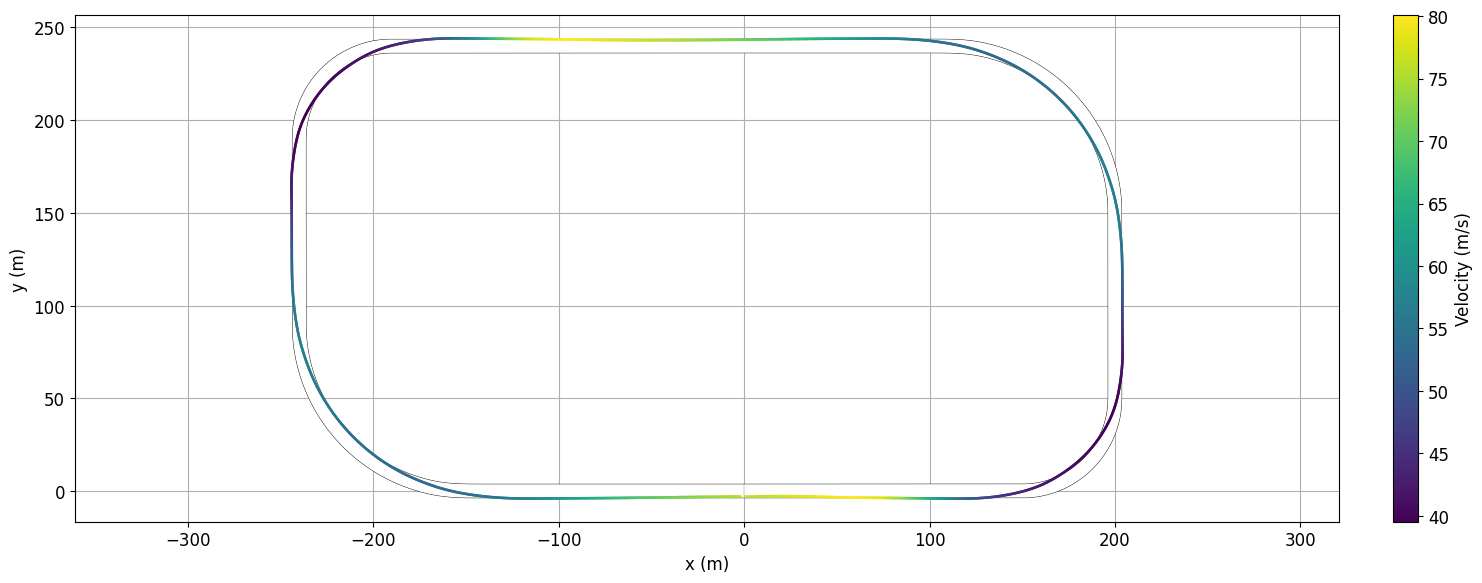

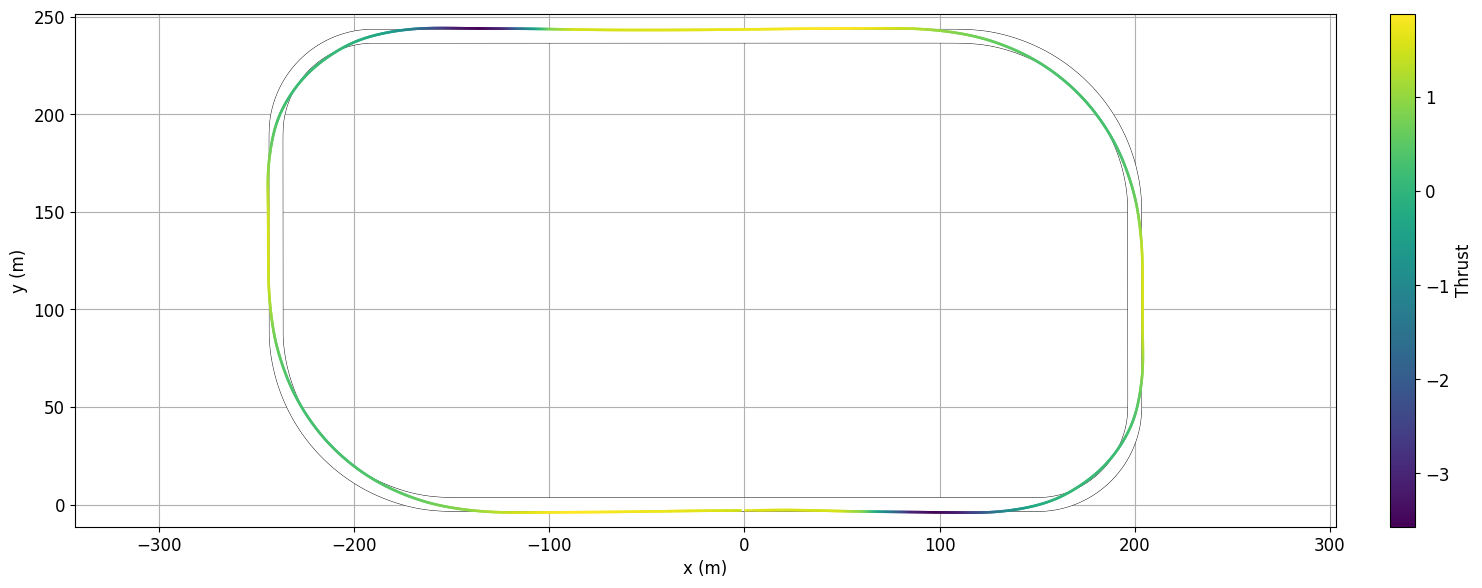

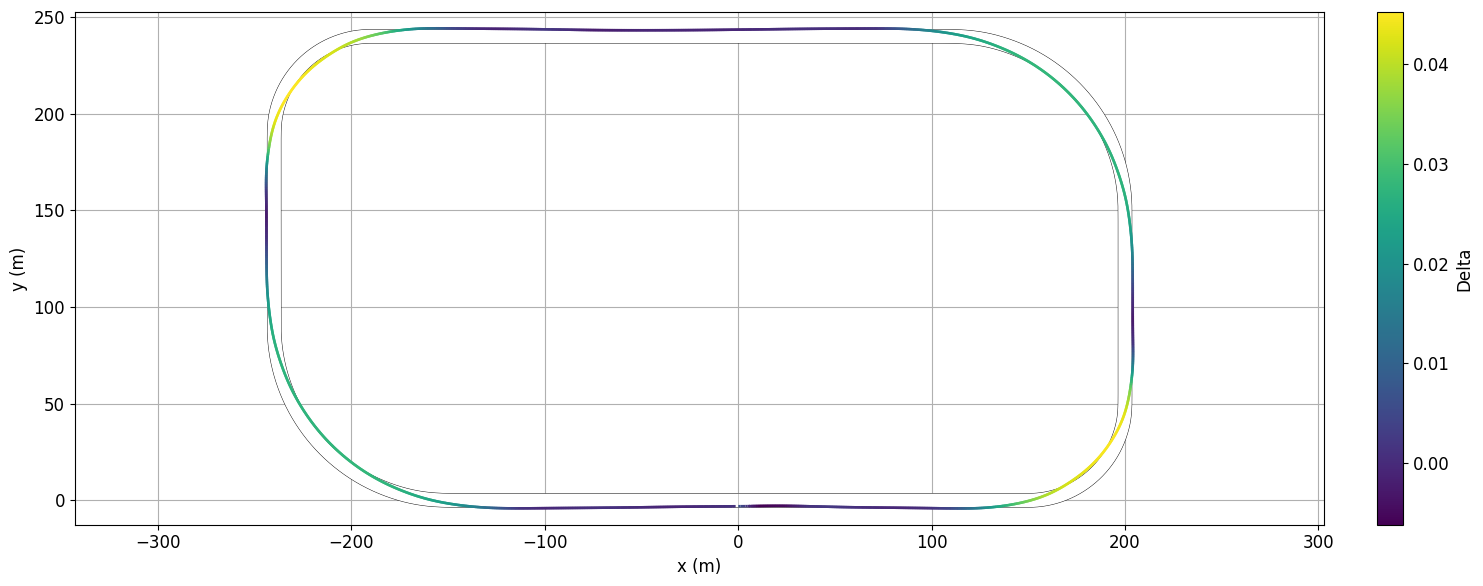

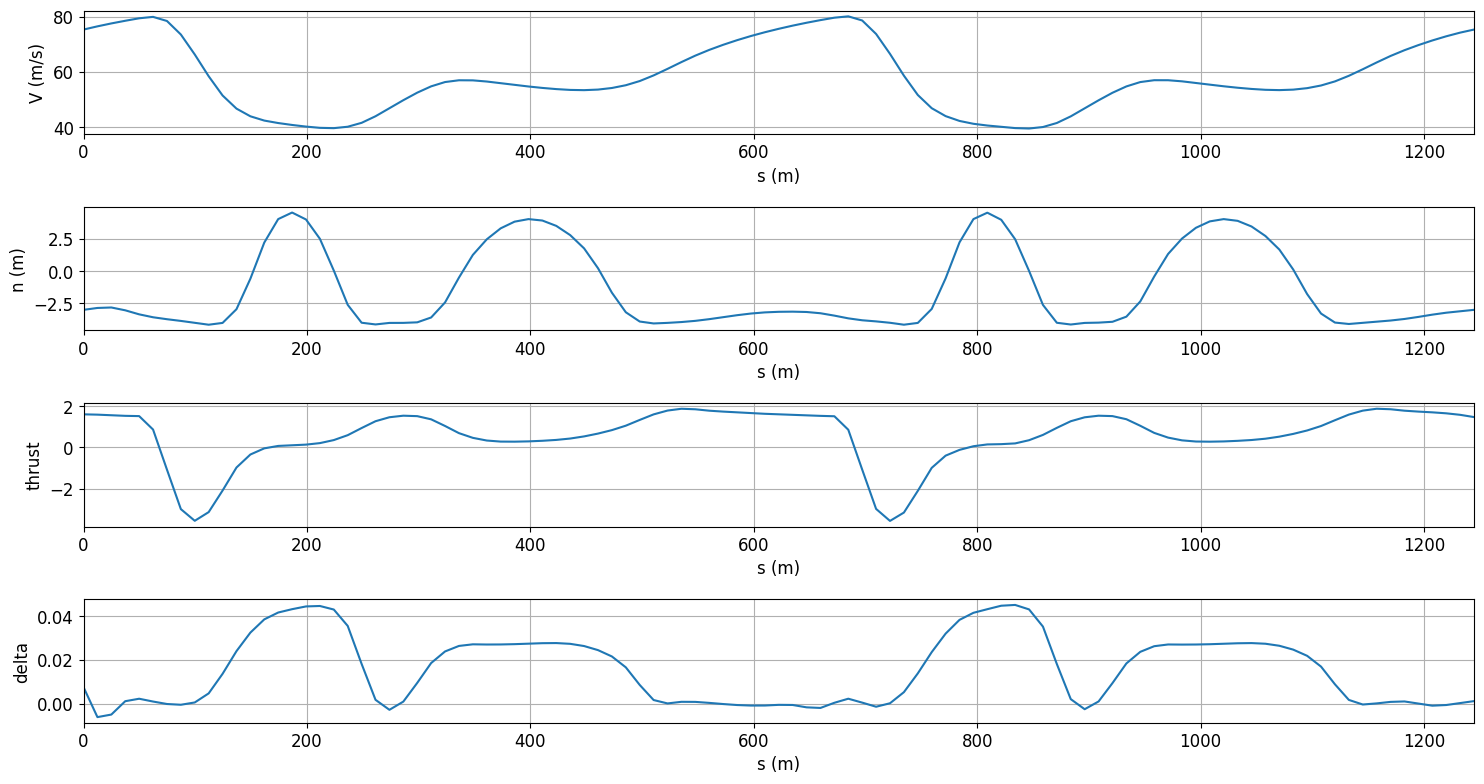

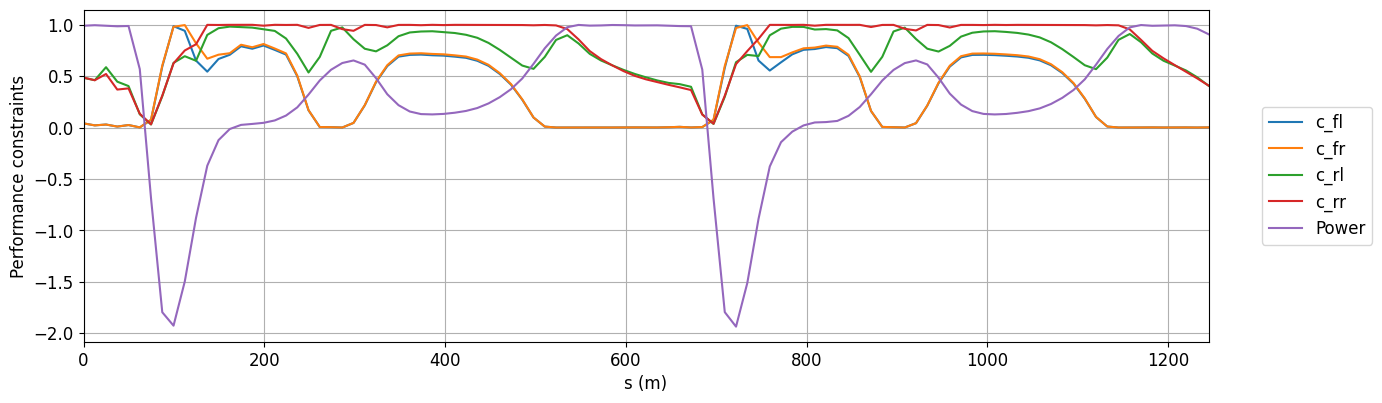

In [19]:
# Get optimized time series
n = p.get_val('traj.phase0.timeseries.n')
s = p.get_val('traj.phase0.timeseries.s')
V = p.get_val('traj.phase0.timeseries.V')
thrust = p.get_val('traj.phase0.timeseries.thrust')
delta = p.get_val('traj.phase0.timeseries.delta')
power = p.get_val('traj.phase0.timeseries.power', units='W')

# We know the optimal distance from the centerline (n). To transform this into the racing
# line we fit a spline to the displaced points. This will let us plot the racing line in
# x/y coordinates
normals = get_gate_normals(finespline, slope)
newgates = []
newnormals = []
newn = []
for i in range(len(n)):
    index = ((s[i] / s_final) * np.array(finespline).shape[1]).astype(
        int)  # interpolation to find the appropriate index
    if index[0] == np.array(finespline).shape[1]:
        index[0] = np.array(finespline).shape[1] - 1
    if i > 0 and s[i] == s[i - 1]:
        continue
    else:
        newgates.append([finespline[0][index[0]], finespline[1][index[0]]])
        newnormals.append(normals[index[0]])
        newn.append(n[i][0])

newgates = reverse_transform_gates(newgates)
displaced_gates = set_gate_displacements(newn, newgates, newnormals)
displaced_gates = np.array((transform_gates(displaced_gates)))

npoints = 1000
# fit the racing line spline to npoints
displaced_spline, gates, gatesd, curv, slope = get_spline(displaced_gates, 1 / npoints, 0)

plt.rcParams.update({'font.size': 12})

def plot_track_with_data(state, s):
    # this function plots the track
    state = np.array(state)[:, 0]
    s = np.array(s)[:, 0]
    s_new = np.linspace(0, s_final, npoints)

    # Colormap and norm of the track plot
    cmap = mpl.colormaps['viridis']
    norm = mpl.colors.Normalize(vmin=np.amin(state), vmax=np.amax(state))

    fig, ax = plt.subplots(figsize=(15, 6))
    # establishes the figure axis limits needed for plotting the track below
    plt.plot(displaced_spline[0], displaced_spline[1], linewidth=0.1, solid_capstyle="butt")

    plt.axis('equal')
    # the linewidth is set in order to match the width of the track
    plt.plot(finespline[0], finespline[1], 'k',
             linewidth=linewidth_from_data_units(8.5, ax),
             solid_capstyle="butt")
    plt.plot(finespline[0], finespline[1], 'w', linewidth=linewidth_from_data_units(8, ax),
             solid_capstyle="butt")  # 8 is the width, and the 8.5 wide line draws 'kerbs'
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

    # plot spline with color
    for i in range(1, len(displaced_spline[0])):
        s_spline = s_new[i]
        index_greater = np.argwhere(s >= s_spline)[0][0]
        index_less = np.argwhere(s < s_spline)[-1][0]

        x = s_spline
        xp = np.array([s[index_less], s[index_greater]])
        fp = np.array([state[index_less], state[index_greater]])
        interp_state = np.interp(x, xp,
                                 fp)  # interpolate the given state to calculate the color

        # calculate the appropriate color
        state_color = norm(interp_state)
        color = cmap(state_color)
        color = mpl.colors.to_hex(color)

        # the track plot consists of thousands of tiny lines:
        point = [displaced_spline[0][i], displaced_spline[1][i]]
        prevpoint = [displaced_spline[0][i - 1], displaced_spline[1][i - 1]]
        if i <= 5 or i == len(displaced_spline[0]) - 1:
            plt.plot([point[0], prevpoint[0]], [point[1], prevpoint[1]], color,
                     linewidth=linewidth_from_data_units(1.5, ax), solid_capstyle="butt",
                     antialiased=True)
        else:
            plt.plot([point[0], prevpoint[0]], [point[1], prevpoint[1]], color,
                     linewidth=linewidth_from_data_units(1.5, ax),
                     solid_capstyle="projecting", antialiased=True)

    clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), fraction=0.02,
                       ax=ax, pad=0.04)  # add colorbar

    if np.array_equal(state, V[:, 0]):
        clb.set_label('Velocity (m/s)')
    elif np.array_equal(state, thrust[:, 0]):
        clb.set_label('Thrust')
    elif np.array_equal(state, delta[:, 0]):
        clb.set_label('Delta')

    plt.tight_layout()
    plt.grid()

# Create the plots
plot_track_with_data(V, s)
plot_track_with_data(thrust, s)
plot_track_with_data(delta, s)

# Plot the main vehicle telemetry
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 8))

# Velocity vs s
axes[0].plot(s,
             p.get_val('traj.phase0.timeseries.V'), label='solution')

axes[0].set_xlabel('s (m)')
axes[0].set_ylabel('V (m/s)')
axes[0].grid()
axes[0].set_xlim(0, s_final)

# n vs s
axes[1].plot(s,
             p.get_val('traj.phase0.timeseries.n', units='m'), label='solution')

axes[1].set_xlabel('s (m)')
axes[1].set_ylabel('n (m)')
axes[1].grid()
axes[1].set_xlim(0, s_final)

# throttle vs s
axes[2].plot(s, thrust)

axes[2].set_xlabel('s (m)')
axes[2].set_ylabel('thrust')
axes[2].grid()
axes[2].set_xlim(0, s_final)

# delta vs s
axes[3].plot(s,
             p.get_val('traj.phase0.timeseries.delta', units=None),
             label='solution')

axes[3].set_xlabel('s (m)')
axes[3].set_ylabel('delta')
axes[3].grid()
axes[3].set_xlim(0, s_final)

plt.tight_layout()

# Performance constraint plot. Tire friction and power constraints
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
plt.subplots_adjust(right=0.82, bottom=0.14, top=0.97, left=0.07)

axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_fl', units=None), label='c_fl')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_fr', units=None), label='c_fr')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_rl', units=None), label='c_rl')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_rr', units=None), label='c_rr')

axes.plot(s, power / pmax, label='Power')

axes.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
axes.set_xlabel('s (m)')
axes.set_ylabel('Performance constraints')
axes.grid()
axes.set_xlim(0, s_final)
plt.show()

In [21]:
from openmdao.utils.assert_utils import assert_near_equal

# Test this example in Dymos' continuous integration process
assert_near_equal(p.get_val('traj.phase0.timeseries.t')[-1], 22.2657, tolerance=0.01)

4.669756254425175e-06

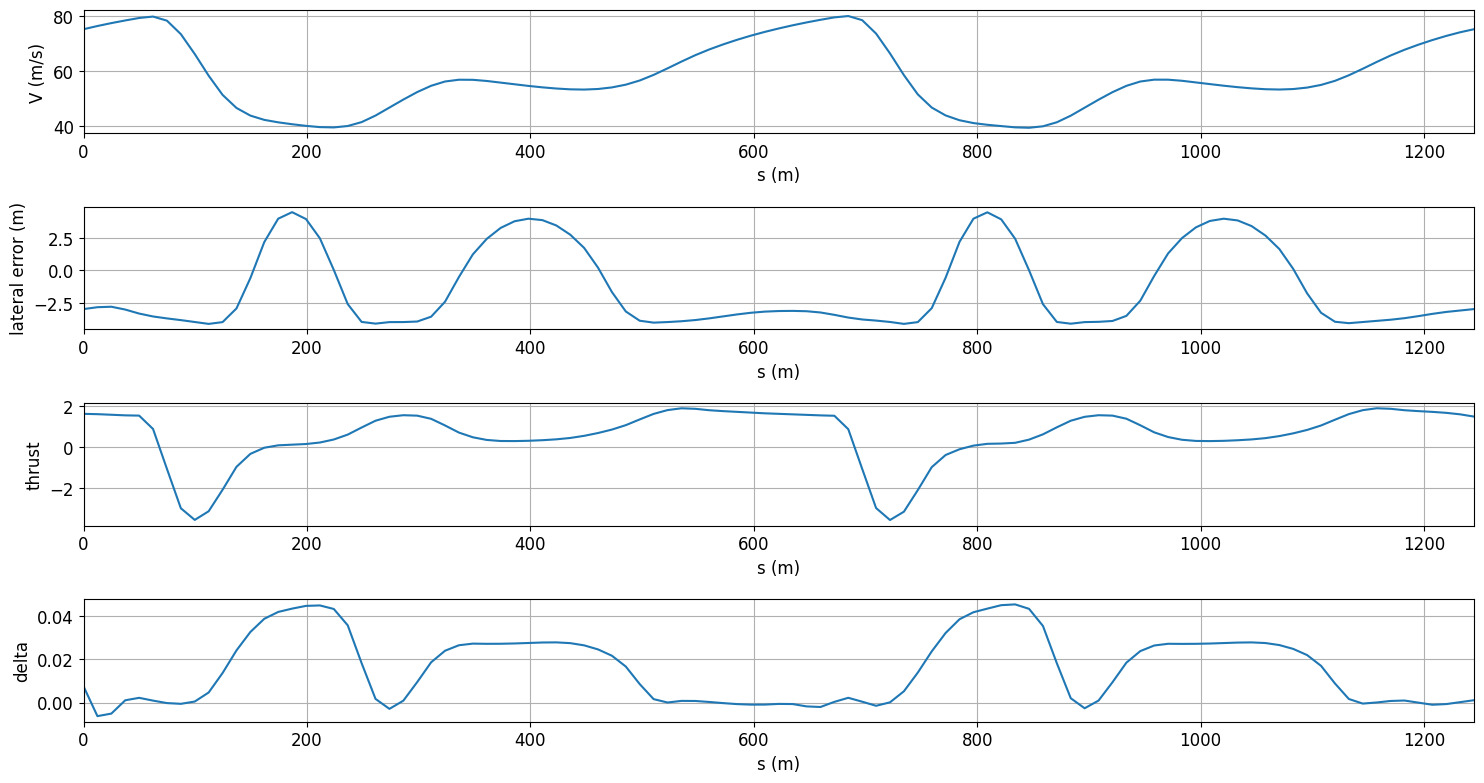

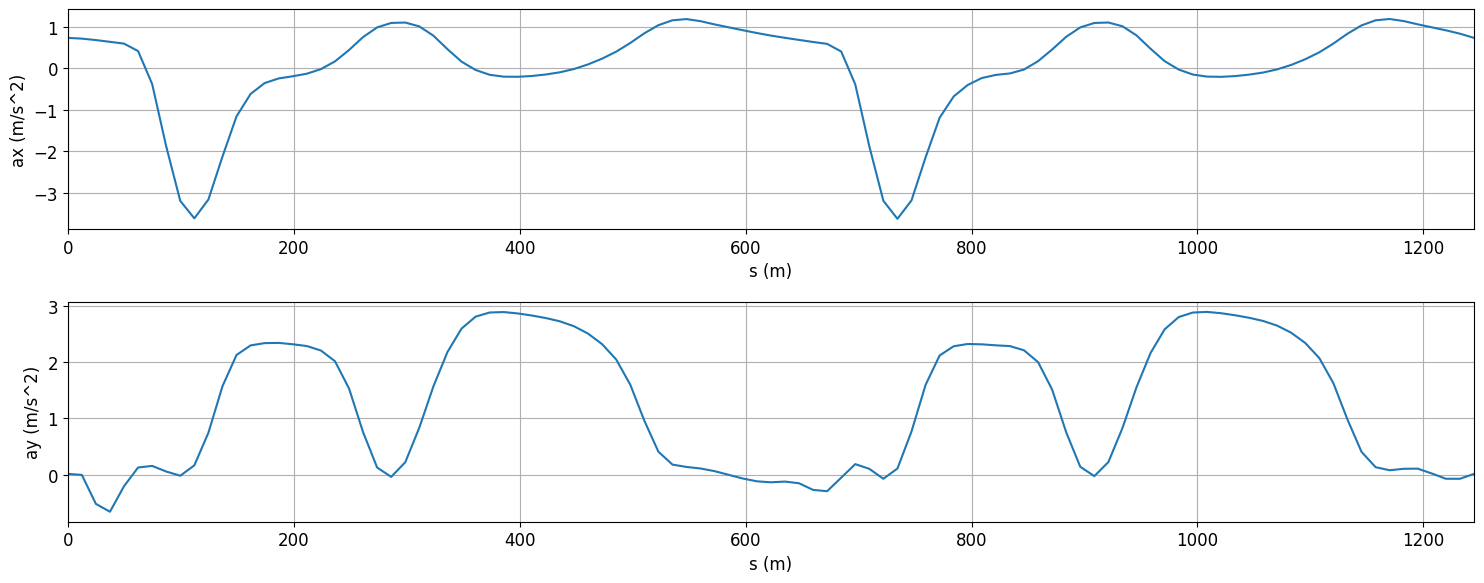

In [26]:
import matplotlib.pyplot as plt

# -- 1) 4'lü subplot: Velocity, n (lateral error), thrust, delta -- #
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)  # Subplotlar arası boşluk

# 1) Velocity vs s
axes[0].plot(s, p.get_val('traj.phase0.timeseries.V', units='m/s'), label='solution')
axes[0].set_xlabel('s (m)')
axes[0].set_ylabel('V (m/s)')
axes[0].grid()
axes[0].set_xlim(0, s_final)

# 2) n (lateral error) vs s
axes[1].plot(s, p.get_val('traj.phase0.timeseries.n', units='m'), label='solution')
axes[1].set_xlabel('s (m)')
axes[1].set_ylabel('lateral error (m)')
axes[1].grid()
axes[1].set_xlim(0, s_final)

# 3) thrust vs s
axes[2].plot(s, thrust, label='thrust')
axes[2].set_xlabel('s (m)')
axes[2].set_ylabel('thrust')
axes[2].grid()
axes[2].set_xlim(0, s_final)

# 4) delta vs s
axes[3].plot(s, p.get_val('traj.phase0.timeseries.delta'), label='solution')
axes[3].set_xlabel('s (m)')
axes[3].set_ylabel('delta')
axes[3].grid()
axes[3].set_xlim(0, s_final)

plt.tight_layout()
plt.show()


# -- 2) İvme grafikleri (ax ve ay) için 2'li subplot -- #
fig, axes_acc = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
plt.subplots_adjust(hspace=0.4)

# ax vs s
axes_acc[0].plot(s,
                 p.get_val('traj.phase0.timeseries.ax', units='m/s**2')/10,
                 label='ax')
axes_acc[0].set_xlabel('s (m)')
axes_acc[0].set_ylabel('ax (m/s^2)')
axes_acc[0].grid()
axes_acc[0].set_xlim(0, s_final)

# ay vs s
axes_acc[1].plot(s,
                 p.get_val('traj.phase0.timeseries.ay', units='m/s**2')/10,
                 label='ay')
axes_acc[1].set_xlabel('s (m)')
axes_acc[1].set_ylabel('ay (m/s^2)')
axes_acc[1].grid()
axes_acc[1].set_xlim(0, s_final)

plt.tight_layout()
plt.show()


In [8]:
print(s)

[[   0.        ]
 [  12.44822972]
 [  24.89645943]
 [  24.89645943]
 [  37.34468915]
 [  49.79291886]
 [  49.79291886]
 [  62.24114858]
 [  74.68937829]
 [  74.68937829]
 [  87.13760801]
 [  99.58583772]
 [  99.58583772]
 [ 112.03406744]
 [ 124.48229715]
 [ 124.48229715]
 [ 136.93052687]
 [ 149.37875658]
 [ 149.37875658]
 [ 161.8269863 ]
 [ 174.27521601]
 [ 174.27521601]
 [ 186.72344573]
 [ 199.17167544]
 [ 199.17167544]
 [ 211.61990516]
 [ 224.06813487]
 [ 224.06813487]
 [ 236.51636459]
 [ 248.9645943 ]
 [ 248.9645943 ]
 [ 261.41282402]
 [ 273.86105373]
 [ 273.86105373]
 [ 286.30928345]
 [ 298.75751316]
 [ 298.75751316]
 [ 311.20574288]
 [ 323.65397259]
 [ 323.65397259]
 [ 336.10220231]
 [ 348.55043202]
 [ 348.55043202]
 [ 360.99866174]
 [ 373.44689145]
 [ 373.44689145]
 [ 385.89512117]
 [ 398.34335088]
 [ 398.34335088]
 [ 410.7915806 ]
 [ 423.23981031]
 [ 423.23981031]
 [ 435.68804003]
 [ 448.13626974]
 [ 448.13626974]
 [ 460.58449946]
 [ 473.03272917]
 [ 473.03272917]
 [ 485.4809588

In [20]:
# ===============================================================
# 1) Gerekli paketlerin kurulumu (Colab ortamında).
#    Bu hücreyi Colab'da ilk kez çalıştırdığınızda
#    paketleri yükler. Sonra runtime'ı yeniden başlatmanız
#    (Runtime -> Restart runtime) gerekebilir.
# ===============================================================
%%capture
!pip install openmdao[notebooks] dymos pyoptsparse

# ===============================================================
# 2) Tüm Python kodu tek hücrede tanımlıyoruz.
#    - Importlar
#    - ODE bileşenleri (CarODE, TireODE, vs.) (stub)
#    - MPCController
#    - CombinedODE
#    - Asıl Dymos/OpenMDAO Problem tanımı
# ===============================================================

import openmdao.api as om
import dymos as dm
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# ODE Bileşenleri (stub / iskelet)

class NormalForceODE(om.ExplicitComponent):
    """
    Araç tekerleklerindeki normal kuvveti hesaplayacak bileşen.
    Basitleştirilmiş stub: Normal kuvvetleri sabit sayılar gibi tutar.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('ax', shape=(nn,), units='m/s**2', desc='Longitudinal accel')
        self.add_input('ay', shape=(nn,), units='m/s**2', desc='Lateral accel')
        self.add_input('V',  shape=(nn,), units='m/s',    desc='Vehicle speed')

        self.add_output('N_fr', shape=(nn,), units='N', desc='Normal force FR')
        self.add_output('N_fl', shape=(nn,), units='N', desc='Normal force FL')
        self.add_output('N_rr', shape=(nn,), units='N', desc='Normal force RR')
        self.add_output('N_rl', shape=(nn,), units='N', desc='Normal force RL')

        # Jacobian basit tutuyoruz (partiallar = 0)
        self.declare_partials('*', '*', val=0.0)

    def compute(self, inputs, outputs):
        # Basit sabit normal kuvvet dağılımı (çok kaba bir yaklaşım)
        nn = len(inputs['ax'])
        for i in range(nn):
            outputs['N_fr'][i] = 2500.0
            outputs['N_fl'][i] = 2500.0
            outputs['N_rr'][i] = 2500.0
            outputs['N_rl'][i] = 2500.0


class TireODE(om.ExplicitComponent):
    """
    Tekerleklerin kayma, kuvvet vs. hesapları.
    Stub: Basitçe tekerlek kuvvetlerini sabit/önemsiz kabul ediyoruz.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('lambda', shape=(nn,), units='rad')
        self.add_input('omega',  shape=(nn,), units='rad/s')
        self.add_input('V',      shape=(nn,), units='m/s')
        self.add_input('N_fr',   shape=(nn,), units='N')
        self.add_input('N_fl',   shape=(nn,), units='N')
        self.add_input('N_rr',   shape=(nn,), units='N')
        self.add_input('N_rl',   shape=(nn,), units='N')
        self.add_input('delta',  shape=(nn,), desc='Steering angle')
        self.add_input('thrust', shape=(nn,), desc='Thrust command')

        # Çıktılar: Tekerlek slip, kuvvet, vb.
        self.add_output('S_fr', shape=(nn,), desc='Front-right slip')
        self.add_output('S_fl', shape=(nn,), desc='Front-left slip')
        self.add_output('S_rr', shape=(nn,), desc='Rear-right slip')
        self.add_output('S_rl', shape=(nn,), desc='Rear-left slip')
        self.add_output('F_fr', shape=(nn,), units='N', desc='Front-right force')
        self.add_output('F_fl', shape=(nn,), units='N', desc='Front-left force')
        self.add_output('F_rr', shape=(nn,), units='N', desc='Rear-right force')
        self.add_output('F_rl', shape=(nn,), units='N', desc='Rear-left force')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        nn = self.options['num_nodes']
        # Kaba sabitler
        for i in range(nn):
            # Slip'leri 0 varsayıyoruz
            outputs['S_fr'][i] = 0.0
            outputs['S_fl'][i] = 0.0
            outputs['S_rr'][i] = 0.0
            outputs['S_rl'][i] = 0.0
            # Tekerlek kuvvetleri => basit orantı thrust*gibi
            # (Gerçekte lastik modeli çok daha kompleks)
            thr = inputs['thrust'][i]
            # Bu 'thr' un, fronta vs. dağılması vs. normalde ilgilenilir
            # Bu stub: Tümü arka tekerlere = thr * 1000 N gibi yapalım
            outputs['F_fr'][i] = 0.0
            outputs['F_fl'][i] = 0.0
            outputs['F_rr'][i] = thr * 1000.0
            outputs['F_rl'][i] = thr * 1000.0


class Curvature(om.ExplicitComponent):
    """
    Pist eğriliği, kappa. Stub: sabit curvature = 0.
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('s', shape=(nn,), units='m', desc='distance along track')
        self.add_output('kappa', shape=(nn,), desc='track curvature', val=0.0)
        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        # Sabit 0 curvature => düz pist
        pass


class CarODE(om.ExplicitComponent):
    """
    Aracın ana dinamiği.
    Stub formülü:
      sdot ~ V (ancak normalde x/y param. vs. )
      ndot ~ ay / ??? -> basit yaklaşım
      alphadot, Vdot, lambdadot, omegadot -> kabaca
      power -> thrust * V (kabaca)
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        # Girdi
        self.add_input('n',       shape=(nn,), units='m')
        self.add_input('alpha',   shape=(nn,), units='rad')
        self.add_input('V',       shape=(nn,), units='m/s')
        self.add_input('lambda',  shape=(nn,), units='rad')
        self.add_input('omega',   shape=(nn,), units='rad/s')
        self.add_input('S_fr',    shape=(nn,))
        self.add_input('S_fl',    shape=(nn,))
        self.add_input('S_rr',    shape=(nn,))
        self.add_input('S_rl',    shape=(nn,))
        self.add_input('F_fr',    shape=(nn,), units='N')
        self.add_input('F_fl',    shape=(nn,), units='N')
        self.add_input('F_rr',    shape=(nn,), units='N')
        self.add_input('F_rl',    shape=(nn,), units='N')
        self.add_input('delta',   shape=(nn,))
        # kappa (pistin eğriliği), vs. eklenebilir

        # Çıktı
        self.add_output('sdot',       shape=(nn,), units='m/s', desc='ds/dt? if time as var')
        self.add_output('ndot',       shape=(nn,), units='m/s', desc='dn/dt?')
        self.add_output('alphadot',   shape=(nn,), units='rad/s')
        self.add_output('omegadot',   shape=(nn,), units='rad/s**2')
        self.add_output('Vdot',       shape=(nn,), units='m/s**2')
        self.add_output('lambdadot',  shape=(nn,), units='rad/s')
        self.add_output('power',      shape=(nn,), units='W')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        n     = inputs['n']
        alpha = inputs['alpha']
        V     = inputs['V']
        # Basit formüller
        nn = len(V)
        for i in range(nn):
            vi = V[i]
            # sdot = V (yani 'ds/dt' = V, eğer 'time'=integration var => bu kısım karışık)
            # Bu demo: s, time karışımı. Kabaca s'i 'time' gibi ele alıyoruz
            outputs['sdot'][i]      = vi
            # Yanal hız => ndot
            # Stub: ndot = 0 (aracın n bileşenini CarODE'ye hesaplatmak istersek
            #                gerçekte yanal hız = V*sin(yaw dev.?).
            # Burada  basitçe ndot = 0 diyelim
            outputs['ndot'][i]      = 0.0
            outputs['alphadot'][i]  = 0.0
            outputs['omegadot'][i]  = 0.0
            outputs['Vdot'][i]      = 0.0
            outputs['lambdadot'][i] = 0.0
            # motor gücü = F_rr * V
            # çok kabaca
            # (Gerçekte anlık thrust*gibi, arka teker kuvvet x hız)
            outputs['power'][i] = inputs['F_rr'][i] * vi

class AccelerationODE(om.ExplicitComponent):
    """
    ax, ay ivmelerini bulmak için.
    Stub: ay = (delta*gibi?), ax=thrust*gibi?
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('V', shape=(nn,), units='m/s')
        self.add_input('lambda', shape=(nn,), units='rad')
        self.add_input('omega',  shape=(nn,), units='rad/s')
        self.add_input('Vdot',   shape=(nn,), units='m/s**2')
        self.add_input('lambdadot', shape=(nn,), units='rad/s')
        self.add_input('ax', shape=(nn,), units='m/s**2')
        self.add_input('ay', shape=(nn,), units='m/s**2')

        self.add_output('axdot', shape=(nn,), units='m/s**3')
        self.add_output('aydot', shape=(nn,), units='m/s**3')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        nn = len(inputs['V'])
        # Stub: Türevler sıfır
        outputs['axdot'] = np.zeros(nn)
        outputs['aydot'] = np.zeros(nn)


class TireConstraintODE(om.ExplicitComponent):
    """
    Lastiğin tutunma kısıtları c_fr, c_fl, c_rr, c_rl <= 1
    Stub: sabit 0.5 diyelim, Dymos path constraint'e sokacağız
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('S_fr', shape=(nn,))
        self.add_input('S_fl', shape=(nn,))
        self.add_input('S_rr', shape=(nn,))
        self.add_input('S_rl', shape=(nn,))
        self.add_input('F_fr', shape=(nn,), units='N')
        self.add_input('F_fl', shape=(nn,), units='N')
        self.add_input('F_rr', shape=(nn,), units='N')
        self.add_input('F_rl', shape=(nn,), units='N')
        self.add_input('N_fr', shape=(nn,), units='N')
        self.add_input('N_fl', shape=(nn,), units='N')
        self.add_input('N_rr', shape=(nn,), units='N')
        self.add_input('N_rl', shape=(nn,), units='N')

        self.add_output('c_fr', shape=(nn,))
        self.add_output('c_fl', shape=(nn,))
        self.add_output('c_rr', shape=(nn,))
        self.add_output('c_rl', shape=(nn,))

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        nn = self.options['num_nodes']
        # Basit => c_xx = (some fraction). 0.5
        for i in range(nn):
            outputs['c_fr'][i] = 0.5
            outputs['c_fl'][i] = 0.5
            outputs['c_rr'][i] = 0.5
            outputs['c_rl'][i] = 0.5


class TimeODE(om.ExplicitComponent):
    """
    ds/dt ve dt/ds arasındaki ilişkiyi türetecek bileşen.
    Stub: dt/ds = 1 / V (kabaca).
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('ndot', shape=(nn,), units='m/s')
        self.add_input('sdot', shape=(nn,), units='m/s')
        self.add_input('omegadot', shape=(nn,), units='rad/s**2')
        self.add_input('lambdadot', shape=(nn,), units='rad/s')
        self.add_input('Vdot', shape=(nn,), units='m/s**2')
        self.add_input('axdot', shape=(nn,), units='m/s**3')
        self.add_input('aydot', shape=(nn,), units='m/s**3')
        self.add_input('alphadot', shape=(nn,), units='rad/s')

        self.add_output('dn_ds', shape=(nn,), units='m/m')
        self.add_output('dV_ds', shape=(nn,), units='(m/s)/m')
        self.add_output('domega_ds', shape=(nn,), units='(rad/s)/m')
        self.add_output('dlambda_ds', shape=(nn,), units='rad/m')
        self.add_output('dalpha_ds', shape=(nn,), units='rad/m')
        self.add_output('dax_ds', shape=(nn,), units='(m/s**2)/m')
        self.add_output('day_ds', shape=(nn,), units='(m/s**2)/m')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        # Stub => her şeyi 0
        outputs['dn_ds']       = 0.0
        outputs['dV_ds']       = 0.0
        outputs['domega_ds']   = 0.0
        outputs['dlambda_ds']  = 0.0
        outputs['dalpha_ds']   = 0.0
        outputs['dax_ds']      = 0.0
        outputs['day_ds']      = 0.0


class TimeAdder(om.ExplicitComponent):
    """
    dt/ds = 1 / V => dt = ds / V
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('sdot', shape=(nn,), units='m/s')
        self.add_output('dt_ds', shape=(nn,), units='s/m')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        sdot = inputs['sdot']
        # dt/ds = 1/(ds/dt) = 1/(sdot), eğer sdot=0 ise?
        # Stub => clip vs. (avoid zero)
        sdot_safe = np.clip(sdot, 0.1, 1e6)
        outputs['dt_ds'] = 1.0 / sdot_safe


# ---------------------------------------------------------------
# 3) MPC Controller (basit oransal yaklaşım)
# ---------------------------------------------------------------
class MPCController(om.ExplicitComponent):
    """
    Basit "MPC benzeri" denetleyici:
      delta_mpc = -K_n * n - K_alpha * alpha
      thrust_mpc -> yanal ivme artınca düşür
    """
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        # Giriş
        self.add_input('n',      shape=(nn,), units='m', desc='Track normal offset')
        self.add_input('alpha',  shape=(nn,), units='rad', desc='Heading error')
        self.add_input('V',      shape=(nn,), units='m/s')
        self.add_input('ax',     shape=(nn,), units='m/s**2')
        self.add_input('ay',     shape=(nn,), units='m/s**2')

        # Çıkış
        self.add_output('delta_mpc',  shape=(nn,), units='rad', desc='Steering angle')
        self.add_output('thrust_mpc', shape=(nn,), desc='Thrust command')

        self.declare_partials('*','*', val=0.0)

    def compute(self, inputs, outputs):
        n      = inputs['n']
        alpha  = inputs['alpha']
        ay     = inputs['ay']
        g      = 9.81
        ay_max = 0.25*g  # +/- 0.25*g

        # 1) Direksiyon denetimi
        K_n     = 0.2
        K_alpha = 0.1
        outputs['delta_mpc'] = -K_n*n - K_alpha*alpha

        # 2) Thrust denetimi
        # |ay| arttıkça thrust'ı azalt
        ay_ratio   = np.clip(np.abs(ay)/ay_max, 0.0, 1.0)
        thrust_full = 0.5  # tam gaz
        thrust_min  = -0.5 # fren
        raw_thrust  = thrust_full*(1.0 - ay_ratio)
        outputs['thrust_mpc'] = np.clip(raw_thrust, thrust_min, thrust_full)


# ---------------------------------------------------------------
# 4) CombinedODE (ODE'lerin gruplanmış hâli + MPCController)
# ---------------------------------------------------------------
class CombinedODE(om.Group):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']

        # 4.1) MPC
        self.add_subsystem(
            name='mpc',
            subsys=MPCController(num_nodes=nn),
            promotes_inputs=['n','alpha','V','ax','ay'],
            promotes_outputs=['delta_mpc','thrust_mpc']
        )

        # 4.2) Normal Force
        self.add_subsystem(
            name='normal',
            subsys=NormalForceODE(num_nodes=nn),
            promotes_inputs=['ax','ay','V'],
            promotes_outputs=['N_fr','N_fl','N_rr','N_rl']
        )

        # 4.3) Tire
        self.add_subsystem(
            name='tire',
            subsys=TireODE(num_nodes=nn),
            promotes_inputs=['lambda','omega','V','N_fr','N_fl','N_rr','N_rl'],
            promotes_outputs=['S_fr','S_fl','S_rr','S_rl','F_fr','F_fl','F_rr','F_rl']
        )
        # Direksiyon ve thrust => MPC çıktısını buraya bağla
        self.promotes('tire', inputs=[('delta','delta_mpc'),
                                      ('thrust','thrust_mpc')])

        # 4.4) Curvature
        self.add_subsystem(name='curv', subsys=Curvature(num_nodes=nn))
        self.connect('curv.kappa','car.kappa', src_indices=None)

        # 4.5) Car
        self.add_subsystem(
            name='car',
            subsys=CarODE(num_nodes=nn),
            promotes_inputs=['n','alpha','V','lambda','omega',
                             'S_fr','S_fl','S_rr','S_rl',
                             'F_fr','F_fl','F_rr','F_rl']
        )
        self.promotes('car', inputs=[('delta','delta_mpc')])
        self.promotes('car', outputs=['sdot','ndot','alphadot','omegadot','Vdot','lambdadot','power'])

        # 4.6) Accel
        self.add_subsystem(
            name='accel',
            subsys=AccelerationODE(num_nodes=nn),
            promotes_inputs=['V','lambda','omega','Vdot','lambdadot','ax','ay'],
            promotes_outputs=['axdot','aydot']
        )

        # 4.7) Tire constraint
        self.add_subsystem(
            name='tireconstraint',
            subsys=TireConstraintODE(num_nodes=nn),
            promotes_inputs=['S_fr','S_fl','S_rr','S_rl',
                             'F_fr','F_fl','F_rr','F_rl',
                             'N_fr','N_fl','N_rr','N_rl'],
            promotes_outputs=['c_rr','c_rl','c_fr','c_fl']
        )

        # 4.8) Time ODE
        self.add_subsystem(
            name='time',
            subsys=TimeODE(num_nodes=nn),
            promotes_inputs=['ndot','sdot','omegadot','lambdadot','Vdot','axdot','aydot','alphadot'],
            promotes_outputs=['dn_ds','dV_ds','domega_ds','dlambda_ds','dalpha_ds','dax_ds','day_ds']
        )

        # 4.9) TimeAdder
        self.add_subsystem(
            name='timeAdder',
            subsys=TimeAdder(num_nodes=nn),
            promotes_inputs=['sdot'],
            promotes_outputs=['dt_ds']
        )


# ---------------------------------------------------------------
# 5) Asıl Dymos / OpenMDAO Problem Kurulumu ve Çalıştırma
# ---------------------------------------------------------------
def run_mpc_demo():
    # 5.1) Pist uzunluğu (örnek): 1000 m
    s_final = 1000.0

    # 5.2) Problem tanımı
    p = om.Problem(model=om.Group())
    traj = dm.Trajectory()
    p.model.add_subsystem('traj', subsys=traj)

    # Tek faz
    phase = dm.Phase(
        ode_class=CombinedODE,
        transcription=dm.GaussLobatto(num_segments=30, order=3, compressed=True)
    )
    traj.add_phase('phase0', phase)

    # 5.3) s (mesafe) => time_opts.
    #     Aslında "integ_var_options" da yapabilirdik, ama basit tutuyoruz:
    phase.set_time_options(
        fix_initial=True, fix_duration=True,
        initial_val=0.0, duration_val=s_final,
        units='m'
    )

    # 5.4) State tanımları
    # n in [-1.75, 1.75]
    phase.add_state('t',       fix_initial=True, fix_final=False, units='s', rate_source='dt_ds')
    phase.add_state('n',       fix_initial=False, fix_final=False, units='m', lower=-1.75, upper=1.75,
                    rate_source='dn_ds', targets=['n'])
    phase.add_state('V',       fix_initial=False, fix_final=False, units='m/s', rate_source='dV_ds', targets=['V'])
    phase.add_state('alpha',   fix_initial=False, fix_final=False, units='rad', rate_source='dalpha_ds', targets=['alpha'])
    phase.add_state('lambda',  fix_initial=False, fix_final=False, units='rad', rate_source='dlambda_ds', targets=['lambda'])
    phase.add_state('omega',   fix_initial=False, fix_final=False, units='rad/s', rate_source='domega_ds', targets=['omega'])
    phase.add_state('ax',      fix_initial=False, fix_final=False, units='m/s**2', rate_source='dax_ds', targets=['ax'])
    phase.add_state('ay',      fix_initial=False, fix_final=False, units='m/s**2', rate_source='day_ds', targets=['ay'])

    # 5.5) Parametre (örnek)
    phase.add_parameter('M', val=800.0, units='kg', opt=False,
                        targets=['car.M','tire.M','tireconstraint.M','normal.M'])

    # 5.6) Kısıtlar
    # a) Lateral ivme = ay in [-0.25*g, 0.25*g]
    g = 9.81
    phase.add_path_constraint('ay', lower=-0.25*g, upper=0.25*g)
    # b) Boylamsal ivme = ax in [-3.5, 3.5]
    phase.add_path_constraint('ax', lower=-3.5, upper=3.5)
    # c) Lastik tutunma c_xx <= 1
    phase.add_path_constraint('c_rr', upper=1.0)
    phase.add_path_constraint('c_rl', upper=1.0)
    phase.add_path_constraint('c_fr', upper=1.0)
    phase.add_path_constraint('c_fl', upper=1.0)
    # d) Motor gücü
    pmax = 5e5  # 500kW
    phase.add_path_constraint('power', upper=pmax)

    # 5.7) Periyodik (cyclic) koşul: final=initial
    traj.link_phases(phases=['phase0','phase0'],
                     vars=['V','n','alpha','omega','lambda','ax','ay'],
                     locs=('final','initial'))

    # 5.8) Objektif: final zaman (t) min
    phase.add_objective('t', loc='final')

    # 5.9) Sürücü (IPOPT)
    p.driver = om.pyOptSparseDriver(optimizer='IPOPT')
    p.driver.opt_settings['max_iter'] = 300
    p.driver.declare_coloring()

    # 5.10) setup
    p.setup(check=True)

    # 5.11) Başlangıç değerleri
    phase.set_state_val('t',       [0.0, 50.0])
    phase.set_state_val('n',       0.0)
    phase.set_state_val('alpha',   0.0)
    phase.set_state_val('V',       20.0)
    phase.set_state_val('lambda',  0.0)
    phase.set_state_val('omega',   0.0)
    phase.set_state_val('ax',      0.0)
    phase.set_state_val('ay',      0.0)

    # 5.12) Çalıştır
    dm.run_problem(p, run_driver=True)

    # 5.13) Sonuç
    tf = p.get_val('traj.phase0.timeseries.t')[-1]
    print(f"Optimizasyon tamamlandı. Final tur süresi: {tf:.4f} s")

    # Basit bir grafik
    sarr = p.get_val('traj.phase0.timeseries.time')  # s mesafesi
    ayarr = p.get_val('traj.phase0.timeseries.ay')
    axarr = p.get_val('traj.phase0.timeseries.ax')
    narr  = p.get_val('traj.phase0.timeseries.n')
    Varr  = p.get_val('traj.phase0.timeseries.V')
    delta = p.get_val('traj.phase0.timeseries.delta_mpc')
    thr   = p.get_val('traj.phase0.timeseries.thrust_mpc')

    fig, axs = plt.subplots(3,2, figsize=(12,8))
    axs[0,0].plot(sarr, Varr, label='V')
    axs[0,0].set_ylabel('Velocity (m/s)')
    axs[0,0].grid(True)

    axs[0,1].plot(sarr, narr, label='n', color='C1')
    axs[0,1].set_ylabel('lateral offset (m)')
    axs[0,1].grid(True)

    axs[1,0].plot(sarr, axarr, label='ax', color='C2')
    axs[1,0].set_ylabel('ax (m/s^2)')
    axs[1,0].grid(True)

    axs[1,1].plot(sarr, ayarr, label='ay', color='C3')
    axs[1,1].set_ylabel('ay (m/s^2)')
    axs[1,1].grid(True)

    axs[2,0].plot(sarr, delta, label='delta', color='C4')
    axs[2,0].set_ylabel('steering (rad)')
    axs[2,0].set_xlabel('s (m)')
    axs[2,0].grid(True)

    axs[2,1].plot(sarr, thr, label='thrust', color='C5')
    axs[2,1].set_ylabel('thrust cmd')
    axs[2,1].set_xlabel('s (m)')
    axs[2,1].grid(True)

    fig.suptitle('Basit MPC + Dymos Örneği', fontsize=14)
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------
# 6) Fonksiyonu çağırıyoruz
# ---------------------------------------------------------------
run_mpc_demo()


ValueError: Invalid parameter in phase `traj.phases.phase0`.
Parameter `M` has invalid target(s).
No such ODE input: 'car.M'.